In [66]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
torch.set_default_dtype(torch.float32)
from flumen import CausalFlowModel,TrunkNet, TrajectoryDataset
from flumen.utils import pack_model_inputs, plot_amari, trajectory,plot_space_time_flat_trajectory_V2
from torch.utils.data import DataLoader

from generate_data import make_trajectory_sampler

from argparse import ArgumentParser

import yaml
from pathlib import Path
import sys
from pprint import pprint
from time import time
import os
os.chdir("C:/Users/20192139/Documents/5ARG45 - Thesis/Code/FlowFunction/flumen")  # Change this to your actual path
import wandb
import pickle
from flumen import CausalFlowModel, print_gpu_info, TrajectoryDataset, TrunkNet
import torch
import seaborn as sns
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

In [67]:
def return_model(path):
    api = wandb.Api()
    model_artifact = api.artifact(path)
    model_path = Path(model_artifact.download())
    model_run = model_artifact.logged_by()
#     print(model_run.summary)
    device = "cpu"
    # Load model state dictionary
    with open(model_path / "state_dict.pth", 'rb') as f:
        state_dict = torch.load(f, map_location=torch.device("cpu"))  # Ensure compatibility

    with open(model_path / "metadata.yaml", 'r') as f:
        metadata: dict = yaml.load(f, Loader=yaml.FullLoader)
#     pprint(metadata)
#     print(metadata["args"])
    trunk_model = TrunkNet(in_size=256,out_size=100,hidden_size=metadata['args']['trunk_size_svd'],use_batch_norm=False)

    model = CausalFlowModel(**metadata["args"],trunk_model=trunk_model)
    model.load_state_dict(state_dict)
    model.eval()
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total_params}")
    return model

device = 'cpu'


## Noisy data during inference

In [65]:

test_data = torch.load("data/Brian2/gaussian_test_vs_don_equaltimesteps.pt")
noise_std = [0.0,0.01,0.05,0.1,0.2,0.5]

### L1 Lossess ###
l1_model = "marijn-eindhoven-university-of-technology/Ablation/flow_model-brian_T2500_S100_LOOP-A_NL_100_L1:v54"
FLOW_model = return_model(l1_model)
device = "cpu"
FLOW_model.to(device)
all_losses_l1 = []
for std in noise_std:
    trajectory_losses = []
    y_pred_flow = []
    for i in range(0,len(test_data['x0'])):
        with torch.no_grad():
            x0_feed = test_data['x0'][i]
            x0_feed += torch.randn_like(x0_feed) * std # add noise to IC
            deltas_feed = test_data['deltas'][i]
            u_feed = test_data['u'][i]
            padded_seq, lengths = pad_packed_sequence(u_feed, batch_first=True)
            noisy_padded_seq = padded_seq.clone()
            noisy_padded_seq[:, :, :-1] += torch.randn_like(padded_seq[:, :, :-1]) * std # add noise to forcing (excluding delta)
            noisy_packed_seq = pack_padded_sequence(
            noisy_padded_seq, 
            lengths.cpu(), 
            batch_first=True, 
            enforce_sorted=False
            )
            y_pred, basis_functions = FLOW_model(x0_feed.to(device), noisy_packed_seq.to(device),test_data['locations'].to(device),deltas_feed.to(device))
    #         y_pred = torch.flip(y_pred, dims=[0])
            y_pred_flow.append(y_pred.to('cpu').numpy())

    y_pred_flow = np.array(y_pred_flow)

    only_flow = True
    if only_flow == True:
        losses_flow_total = []
        # iterate over trajectories
        for i in range(len(test_data['y'])):
            y = test_data['y'][i]
            y_pred_flow_i = np.flip(y_pred_flow[i], axis=0)
            losses_flow_total.append(np.mean(np.abs(y_pred_flow_i - y))) # L1
        losses_flow_total = np.array(losses_flow_total)
        all_losses_l1.append(losses_flow_total)
        print('l1 error flow: ', np.mean(losses_flow_total), "std: ", np.std(losses_flow_total))

WARNING    C:\Users\20192139\AppData\Local\Temp\ipykernel_15692\2849550689.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("data/Brian2/gaussian_t

True
Total trainable parameters: 1066351
l1 error flow:  0.036033498551926654 std:  0.019712398313730922
l1 error flow:  0.036087423128727966 std:  0.019302811799732488
l1 error flow:  0.03937203280475116 std:  0.017385526612137273
l1 error flow:  0.05342916929615141 std:  0.01788202159658234
l1 error flow:  0.08033138446223251 std:  0.02025630903746977
l1 error flow:  0.12203169254941384 std:  0.0186110159223606


In [54]:
test_data = torch.load("data/Brian2/gaussian_test_vs_don_equaltimesteps.pt")
noise_std = [0.0,0.01,0.05,0.1,0.2,0.5]

### L2 Lossess ###
l2_model = "marijn-eindhoven-university-of-technology/Ablation/flow_model-brian_T2500_S100_LOOP-A_NL_100_MSE:v25"
FLOW_model = return_model(l2_model)
device = "cpu"
FLOW_model.to(device)
all_losses_mse = []
for std in noise_std:
    trajectory_losses = []
    y_pred_flow = []
    for i in range(0,len(test_data['x0'])):
        with torch.no_grad():
            x0_feed = test_data['x0'][i]
            x0_feed += torch.randn_like(x0_feed) * std # add noise to IC
            deltas_feed = test_data['deltas'][i]
            u_feed = test_data['u'][i]
            padded_seq, lengths = pad_packed_sequence(u_feed, batch_first=True)
            noisy_padded_seq = padded_seq.clone()
            noisy_padded_seq[:, :, :-1] += torch.randn_like(padded_seq[:, :, :-1]) * std # add noise to forcing (excluding delta)
            noisy_packed_seq = pack_padded_sequence(
            noisy_padded_seq, 
            lengths.cpu(), 
            batch_first=True, 
            enforce_sorted=False
            )
            y_pred, basis_functions = FLOW_model(x0_feed.to(device), noisy_packed_seq.to(device),test_data['locations'].to(device),deltas_feed.to(device))
    #         y_pred = torch.flip(y_pred, dims=[0])
            y_pred_flow.append(y_pred.to('cpu').numpy())

    y_pred_flow = np.array(y_pred_flow)

    only_flow = True
    if only_flow == True:
        losses_flow_total = []
        # iterate over trajectories
        for i in range(len(test_data['y'])):
            y = test_data['y'][i]
            y_pred_flow_i = np.flip(y_pred_flow[i], axis=0)
            losses_flow_total.append(np.mean((y_pred_flow_i - y)**2)) # L2

        losses_flow_total = np.array(losses_flow_total)
        all_losses_mse.append(losses_flow_total)
        print('mse error flow: ', np.mean(losses_flow_total), "std: ", np.std(losses_flow_total))

WARNING    C:\Users\20192139\AppData\Local\Temp\ipykernel_30416\985759770.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("data/Brian2/gaussian_te

True


WARNING    C:\Users\20192139\AppData\Local\Temp\ipykernel_30416\122768488.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=torch.

Total trainable parameters: 1066351
mse error flow:  0.01261488218115065 std:  0.00882804267637403
mse error flow:  0.012664378830775804 std:  0.008836816783094533
mse error flow:  0.014461555361421905 std:  0.009281016193729057
mse error flow:  0.018898811176048868 std:  0.00992949313654605
mse error flow:  0.027647939812966375 std:  0.010838596845234319
mse error flow:  0.042588331958938346 std:  0.010581605027243783


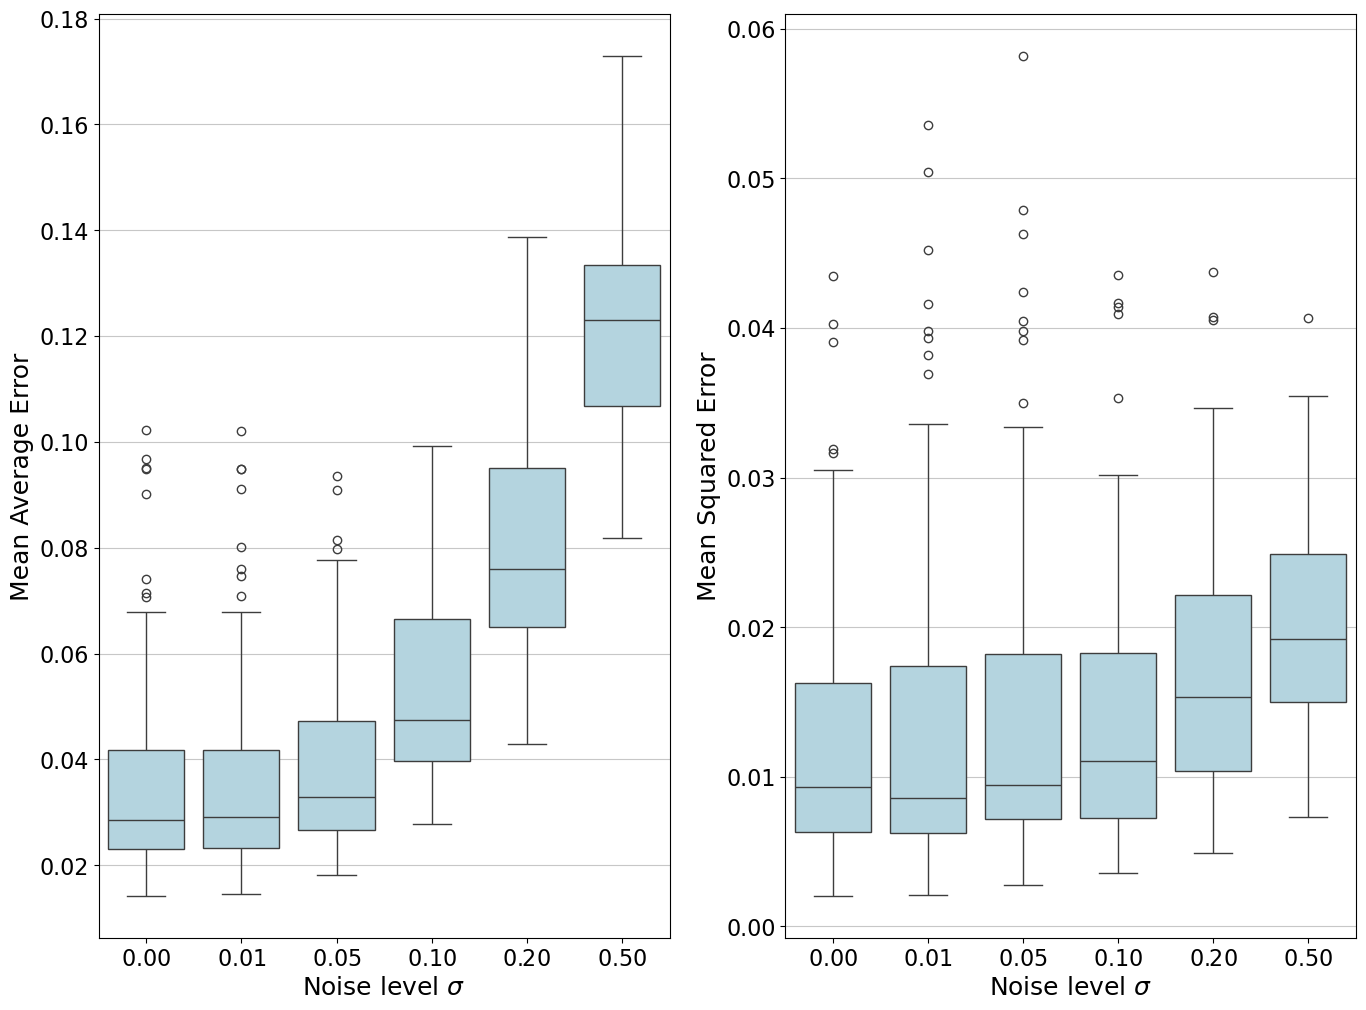

In [70]:
all_losses_x10_l1 = [arr * 1 for arr in all_losses_l1]
all_losses_x10_mse = [arr * 1 for arr in all_losses_mse]
# Number of predictions (for figure height scaling)
n_preds = 1

# Style settings
mpl.rcParams.update({
    'text.usetex': False,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 20,
    'font.size': 18,
    'axes.grid': True,
    'grid.linestyle': '-',
    'grid.alpha': 0.7,
    'lines.linewidth': 1.5,
    'figure.figsize': [14, 5.5 * (n_preds + 0.9)],  # width fixed, height scales
})

# Example data (scaled by 10)
np.random.seed(0)


# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, sharey=False)  # sharey makes them comparable

# Left subplot
sns.boxplot(data=all_losses_x10_l1, color='lightblue', ax=axes[0])
axes[0].set_xticks(range(6))
axes[0].set_xticklabels([r"$0.00$", "$0.01$", "$0.05$", "$0.10$", "$0.20$","$0.50$"])
axes[0].set_title("")
axes[0].set_ylabel("Mean Average Error")
axes[0].set_xlabel("Noise level $\sigma$")

# Right subplot
sns.boxplot(data=all_losses_x10_mse, color='lightblue', ax=axes[1])
axes[1].set_xticks(range(6))
axes[1].set_xticklabels([r"$0.00$", "$0.01$", "$0.05$", "$0.10$", "$0.20$","$0.50$"])
axes[1].set_title("")
axes[1].set_ylabel("Mean Squared Error")
axes[1].set_xlabel(r"Noise level $\sigma$")

plt.tight_layout()
plt.show()

## Noisy training data

In [71]:
test_data = torch.load("data/Brian2/gaussian_test_vs_don_equaltimesteps.pt")
l1_model_s00 = "marijn-eindhoven-university-of-technology/Ablation/flow_model-brian_T2500_S100_LOOP-A_NL_100_L1:v54"

l1_model_s01 = "marijn-eindhoven-university-of-technology/Noise/flow_model-brian2_noise_T2500-std_001_V2:v37"
l1_model_s05 = "marijn-eindhoven-university-of-technology/Noise/flow_model-brian2_noise_T2500-std_005_V2:v30"
l1_model_s10 = "marijn-eindhoven-university-of-technology/Noise/flow_model-brian2_noise_T2500-std_010_V2:v20"
l1_model_s20 = "marijn-eindhoven-university-of-technology/Noise/flow_model-brian2_noise_T2500-std_020_V2:v11"
l1_model_s50 = "marijn-eindhoven-university-of-technology/Noise/flow_model-brian2_noise_T2500-std_050_V2:v4"

l1_model_s00 = return_model(l1_model_s00)
l1_model_s01 = return_model(l1_model_s01)
l1_model_s05 = return_model(l1_model_s05)
l1_model_s10 = return_model(l1_model_s10)
l1_model_s20 = return_model(l1_model_s20)
l1_model_s50 = return_model(l1_model_s50)

models = [l1_model_s00,l1_model_s01,l1_model_s05,l1_model_s10,l1_model_s20,l1_model_s50]
    
all_losses_l1 = []
for model in models:
    model.to(device)
    trajectory_losses = []
    y_pred_flow = []
    for i in range(0,len(test_data['x0'])):
        with torch.no_grad():
            x0_feed = test_data['x0'][i]
            t_feed = test_data['t'][i]
            u_feed = test_data['u'][i]
            deltas_feed = test_data['deltas'][i]
            y_pred, basis_functions = model(x0_feed.to(device), u_feed.to(device),test_data['locations'].to(device),deltas_feed.to(device))
            y_pred_flow.append(y_pred.to('cpu').numpy())
    
    y_pred_flow = np.array(y_pred_flow)      
    
    losses_flow_total = []
    # iterate over trajectories
    for i in range(len(test_data['y'])):
        y = test_data['y'][i]
        y_pred_flow_i = np.flip(y_pred_flow[i], axis=0)
        losses_flow_total.append(np.mean(np.abs(y_pred_flow_i - y))) # L1
#         losses_flow_total.append(np.mean((y_pred_flow_i - y)**2)) # L2
    losses_flow_total = np.array(losses_flow_total)
    all_losses_l1.append(losses_flow_total)
    print('l1 flow: ', np.mean(losses_flow_total), "std: ", np.std(losses_flow_total))

WARNING    C:\Users\20192139\AppData\Local\Temp\ipykernel_15692\3962861969.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("data/Brian2/gaussian_t

True


WARNING    C:\Users\20192139\AppData\Local\Temp\ipykernel_15692\156742266.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=torch.

Total trainable parameters: 1066351


wandb:   2 of 2 files downloaded.  


True
Total trainable parameters: 1066351


wandb:   2 of 2 files downloaded.  


True
Total trainable parameters: 1066351


wandb:   2 of 2 files downloaded.  


True
Total trainable parameters: 1066351


wandb:   2 of 2 files downloaded.  


True
Total trainable parameters: 1066351


wandb:   2 of 2 files downloaded.  


True
Total trainable parameters: 1066351
l1 flow:  0.036033498551926654 std:  0.019712398313730922
l1 flow:  0.04030240248570827 std:  0.023012502337443546
l1 flow:  0.043568533519034135 std:  0.02091129448593101
l1 flow:  0.05263112711846826 std:  0.02074085281362855
l1 flow:  0.062237026213600596 std:  0.021814447582374875
l1 flow:  0.08927075424128647 std:  0.017448981914226676


In [72]:
test_data = torch.load("data/Brian2/gaussian_test_vs_don_equaltimesteps.pt")
mse_model_s00 = "marijn-eindhoven-university-of-technology/Ablation/flow_model-brian_T2500_S100_LOOP-A_NL_100_MSE:v25"

mse_model_s01 = "marijn-eindhoven-university-of-technology/Noise/flow_model-brian2_noise_T2500-std_001_V2_MSE:v21"
mse_model_s05 = "marijn-eindhoven-university-of-technology/Noise/flow_model-brian2_noise_T2500-std_005_V2_MSE:v22"
mse_model_s10 = "marijn-eindhoven-university-of-technology/Noise/flow_model-brian2_noise_T2500-std_010_V2_MSE:v15"
mse_model_s20 = "marijn-eindhoven-university-of-technology/Noise/flow_model-brian2_noise_T2500-std_020_V2_MSE:v9"
mse_model_s50 = "marijn-eindhoven-university-of-technology/Noise/flow_model-brian2_noise_T2500-std_050_V2_MSE:v5"

mse_model_s00 = return_model(mse_model_s00)
mse_model_s01 = return_model(mse_model_s01)
mse_model_s05 = return_model(mse_model_s05)
mse_model_s10 = return_model(mse_model_s10)
mse_model_s20 = return_model(mse_model_s20)
mse_model_s50 = return_model(mse_model_s50)

models = [mse_model_s00,mse_model_s01,mse_model_s05,mse_model_s10,mse_model_s20,mse_model_s50]
    
all_losses_mse = []
for model in models:
    model.to(device)
    trajectory_losses = []
    y_pred_flow = []
    for i in range(0,len(test_data['x0'])):
        with torch.no_grad():
            x0_feed = test_data['x0'][i]
            t_feed = test_data['t'][i]
            u_feed = test_data['u'][i]
            deltas_feed = test_data['deltas'][i]
            y_pred, basis_functions = model(x0_feed.to(device), u_feed.to(device),test_data['locations'].to(device),deltas_feed.to(device))
            y_pred_flow.append(y_pred.to('cpu').numpy())
    
    y_pred_flow = np.array(y_pred_flow)      
    
    losses_flow_total = []
    # iterate over trajectories
    for i in range(len(test_data['y'])):
        y = test_data['y'][i]
        y_pred_flow_i = np.flip(y_pred_flow[i], axis=0)
#         losses_flow_total.append(np.mean(np.abs(y_pred_flow_i - y))) # L1
        losses_flow_total.append(np.mean((y_pred_flow_i - y)**2)) # L2
    losses_flow_total = np.array(losses_flow_total)
    all_losses_mse.append(losses_flow_total)
    print('mse flow: ', np.mean(losses_flow_total), "std: ", np.std(losses_flow_total))

WARNING    C:\Users\20192139\AppData\Local\Temp\ipykernel_15692\2460813199.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("data/Brian2/gaussian_t

True


WARNING    C:\Users\20192139\AppData\Local\Temp\ipykernel_15692\156742266.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=torch.

Total trainable parameters: 1066351


wandb:   2 of 2 files downloaded.  


True
Total trainable parameters: 1066351


wandb:   2 of 2 files downloaded.  


True
Total trainable parameters: 1066351


wandb:   2 of 2 files downloaded.  


True
Total trainable parameters: 1066351


wandb:   2 of 2 files downloaded.  


True
Total trainable parameters: 1066351


wandb:   2 of 2 files downloaded.  


True
Total trainable parameters: 1066351
mse flow:  0.01261488218115065 std:  0.00882804267637403
mse flow:  0.013330922934568955 std:  0.011256694307034678
mse flow:  0.014473719319862697 std:  0.011274852829107515
mse flow:  0.013806429469042031 std:  0.00890052262557142
mse flow:  0.017333977169043325 std:  0.008802461795490624
mse flow:  0.02012518818384184 std:  0.0070335909454961945


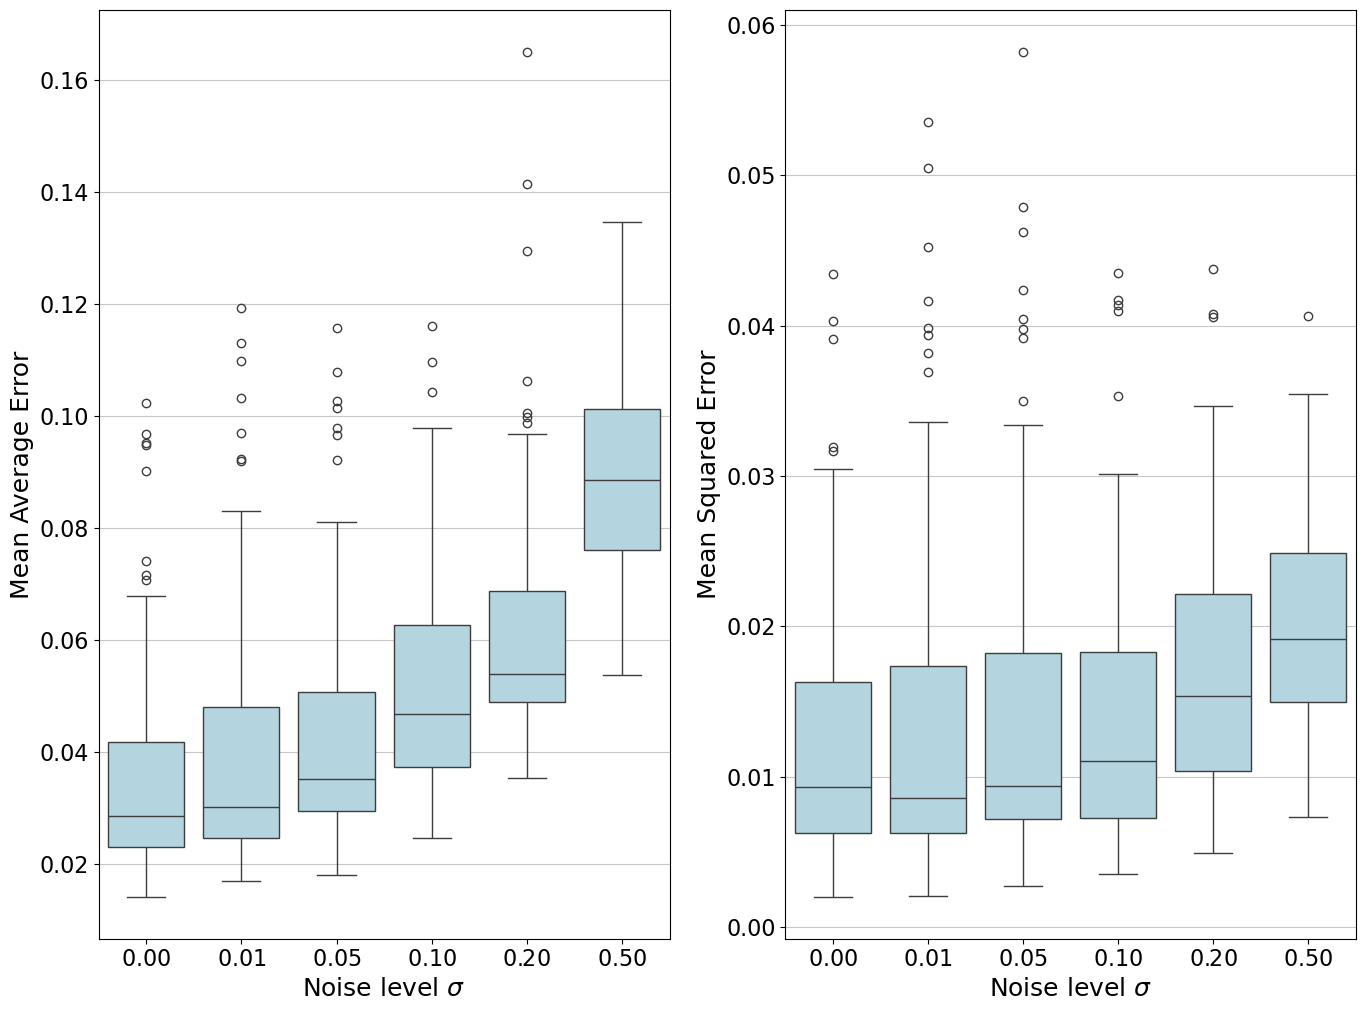

In [73]:
all_losses_x10_l1 = [arr * 1 for arr in all_losses_l1]
all_losses_x10_mse = [arr * 1 for arr in all_losses_mse]
# all_losses_x10_l1 = all_losses_x10_l1[::-1]
# all_losses_x10_mse = all_losses_x10_mse[::-1]

# Number of predictions (for figure height scaling)
n_preds = 1

# Style settings
mpl.rcParams.update({
    'text.usetex': False,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 20,
    'font.size': 18,
    'axes.grid': True,
    'grid.linestyle': '-',
    'grid.alpha': 0.7,
    'lines.linewidth': 1.5,
    'figure.figsize': [14, 5.5 * (n_preds + 0.9)],  # width fixed, height scales
})

# Example data (scaled by 10)
np.random.seed(0)


# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, sharey=False)  # sharey makes them comparable

# Left subplot
sns.boxplot(data=all_losses_x10_l1, color='lightblue', ax=axes[0])
axes[0].set_xticks(range(6))
axes[0].set_xticklabels([r"$0.00$", "$0.01$", "$0.05$", "$0.10$", "$0.20$","$0.50$"])
axes[0].set_title("")
axes[0].set_ylabel("Mean Average Error")
axes[0].set_xlabel("Noise level $\sigma$")

# Right subplot
sns.boxplot(data=all_losses_x10_mse, color='lightblue', ax=axes[1])
axes[1].set_xticks(range(6))
axes[1].set_xticklabels([r"$0.00$", "$0.01$", "$0.05$", "$0.10$", "$0.20$","$0.50$"])
axes[1].set_title("")
axes[1].set_ylabel("Mean Squared Error")
axes[1].set_xlabel("Noise level $\sigma$")

plt.tight_layout()
plt.show()